<img src="fig/scikit-hep-logo.svg" style="height: 200px; margin-left: auto; margin-bottom: -75px">

# Scikit-HEP tutorial for the STAR collaboration

This notebook shows you how to do physics analysis in Python using Scikit-HEP tools: Uproot, Awkward Array, Vector, hist, etc., and it uses a STAR PicoDST file as an example. I presented this tutorial on Zoom on September 13, 2021 (see [STAR collaboration website](https://drupal.star.bnl.gov/STAR/meetings/star-collaboration-meeting-september-2021/juniors-day), if you have access). You can also find it on GitHub at [jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial](https://github.com/jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial).

You can [run this notebook on Binder](https://mybinder.org/v2/gh/jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial/HEAD?urlpath=lab/tree/tutorial.ipynb), which loads all of the package dependencies on Binder's servers; you don't have to install anything on your computer. But if you would like to run it on your computer, see the [requirements.txt](https://github.com/jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial/blob/main/requirements.txt) file. This specifies exact versions of dependencies that are known to work for this notebook, though if you plan to use these packages later on, you'll want the latest versions of each.

The first 5 sections are introductory, and the last contains exercises. In the live tutorial, we spent one hour on the introductory material and one hour in small groups, working on the exercises.

## 1. Python: interactively building up an analysis

<img src="fig/python-logo.svg" style="height: 150px">

### Introduction: why Python?

**It's where the party's at.**

I mean it: the best argument for Python is that there's a huge community of _people_ who can help you and _people_ developing infrastructure.

You probably learned Python in a university course, and you'll probably use it a lot in your career.

<br><br><br>

**Python is especially popular for data analysis:**

<img src="fig/analytics-by-language.svg" width="800px">

See also Jake VanderPlas's [_Unexpected Effectiveness of Python in Science_](https://speakerdeck.com/jakevdp/the-unexpected-effectiveness-of-python-in-science) talk (2017).

<br><br><br>

**Python is one of a large class of languages in which "debugging mode is always on."**

   * Except for bugs in external libraries (and very rare bugs in the language itself), you can't cause a segmentation fault or memory leak.
   * Errors produce a stack trace _with line numbers_.
   * You can print any object.
   * Interactive debuggers are superfluous; the language itself is interactive (raise an exception at a break point that exports variables).
   * Although long-running programs are slow, it _starts up_ quickly, minimizing the debug cycle.

C++ is not one of these languages.

<br><br><br>

**"Always debugging" has a cost: performance.**

Most of Python's design choices prevent fast computation:

   * runtime type checking
   * garbage collection
   * boxing numbers as objects
   * no value types or move semantics at all (all Python references are "pointer chasing")
   * virtual machine indirection
   * Global Interpreter Lock (GIL) prevents threads from running in parallel

_(Maybe not a necessary cost: [Julia](https://julialang.org/) might be exempt, but Julia is not popular—yet.)_

<br><br><br>

**And yet, scientists with big datasets have made Python their home.**

This was only possible because an ecosystem grew around _arrays_ and _array-oriented programming._

<img src="fig/harris-array-programming-nature.png" width="800px">

From Harris, C.R., Millman, K.J., van der Walt, S.J. _et al._ Array programming with NumPy. _Nature_ **585,** 357–362 (2020).
<br>
https://doi.org/10.1038/s41586-020-2649-2

<br><br><br>

**Array-oriented programming is also the paradigm of GPU programming.**

The slowness of Python might have pushed us toward it, but dividing your work into

  * complex bookkeeping that doesn't need to be fast and
  * a mathematical formula to compute on billions of data points

is also the right way to massively parallelize.

<br><br><br>

### What is Scikit-HEP?

[Scikit-HEP](https://scikit-hep.org/) is a collection of Python packages for array-oriented data analysis in particle physics.

(I know, "High Energy" does not describe all of Particle Physics, but Scikit-PP was a worse name.)

The goal of this umbrella organization is to make sure that these packages

  * work well together
  * work well with the Python ecosystem (NumPy, Pandas, Matplotlib, ...) and the traditional HEP ecosystem (ROOT, formats, generators, ...)
  * are packaged well and designed well, to minimize physicist frustration!

I'm the author of Uproot and Awkward Array, so I'll have the most to say about these.

But the context is that they works with a suite of other libraries.

<br><br><br>

### Python language features that we'll be using

We don't have time for an intro course, but many exist.

<br><br><br>

The basic control structures:

In [ ]:
x = 5

In [ ]:
if x < 5:
    print("small")
else:
    print("big")

In [ ]:
for i in range(x):
    print(i)

are less relevant for this tutorial because these are what we avoid when working with large arrays.

<br><br><br>

We will be focusing on operations like

```python
import compiled_library

compiled_library.do_computationally_expensive_thing(big_array)
```

because array-oriented Python is about separating small scale, complex bookkeeping (with `if` and `for`) from large-scale processing in compiled libraries.

<br><br><br>

The trick is for the Python-side code to be expressive enough and the compiled code to be general enough that you don't need a new `compiled_library` for every little thing.

<br><br><br>

Much of this expressivity grew up around Python's syntax for slicing lists:

In [ ]:
some_list = [0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]

Single-element access is like C (counting starts at zero):

In [ ]:
some_list[0]

In [ ]:
some_list[4]

Except when the index is negative; then it counts from the end of the list.

In [ ]:
some_list[-1]

In [ ]:
some_list[-2]

Running off the end of a list is an exception, not a segmentation fault or data corruption.

In [ ]:
some_list[10]

In [ ]:
some_list[-11]

With a colon (`:`), you can also select ranges. The _start_ of each range is included; the _stop_ is excluded.

In [ ]:
some_list[2:7]

In [ ]:
some_list[-6:]

Out-of-bounds ranges don't cause exceptions; they get clipped.

In [ ]:
some_list[8:100]

In [ ]:
some_list[-1000:-500]

Slices have a third argument for how many elements to skip between each step.

In [ ]:
some_list[1:10:2]

In [ ]:
some_list[::2]

This _step_ is not as useful as the _start_ and _stop_, but you can always reverse a list:

In [ ]:
some_list[::-1]

The _start_, _stop_, and _step_ are exactly the arguments of `range`:

In [ ]:
for i in range(1, 9, 3):
    print(i)

In [ ]:
some_list[1:9:3]

<br><br><br>

In Python, "dicts" (mappings, like `std::map`) are just as important as lists (like `std::vector`).

They use the square-bracket syntax in a different way:

In [ ]:
some_dict = {"one": 1, "two": 2, "three": 3, "four": 4, "five": 5}

In [ ]:
some_dict["two"]

In [ ]:
some_dict["not in dict"]

<br><br><br>

Apart from function calls, arithmetic, variables and assignment—which are the same in all mainstream languages—slicing is the only language feature we need for NumPy.

<br><br><br>

## 2. NumPy: thinking one array at a time

<img src="fig/numpy-logo.svg" style="height: 150px">

### Introduction

NumPy is a Python library consisting of one major data type, `np.ndarray`, and a suite of functions to manipulate objects of that type.

<br><br><br>

<img src="fig/Numpy_Python_Cheat_Sheet.svg" width="100%">

<br><br><br>

This is "array-oriented." In each step, you decide what to do to _all values in a large dataset_.

There is a tradition of languages built around this paradigm. Most of them have been for interactive data processing. NumPy is unusual in that it's a library.

<img src="fig/apl-timeline.svg" width="800px">

<br><br><br>

### Slicing in NumPy

NumPy has the same slicing syntax for arrays as Python has for lists.

In [ ]:
import numpy as np

In [ ]:
some_array = np.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [ ]:
some_array[3]

In [ ]:
some_array[-2]

In [ ]:
some_array[-3::-1]

But NumPy slices can operate on multiple dimensions.

In [ ]:
array3d = np.arange(2*3*5).reshape(2, 3, 5)
array3d

In [ ]:
array3d[1:, 1:, 1:]

Python lists _do not_ do this.

In [ ]:
list3d = array3d.tolist()
list3d

In [ ]:
list3d[1:, 1:, 1:]

NumPy slices can have mixed types:

In [ ]:
array3d[:, -1, -1]

<img src="fig/numpy-slicing.png" width="400px">

Most importantly, NumPy slices can also be arrays.

In [ ]:
some_array    = np.array([ 0.0,  1.1,  2.2,  3.3,  4.4,   5.5,  6.6,   7.7,  8.8,   9.9])
boolean_slice = np.array([True, True, True, True, True, False, True, False, True, False])

some_array[boolean_slice]

In [ ]:
integer_slice = np.array([4, 2, 2, 0, 9, 8, 3])

some_array[integer_slice]

In [ ]:
some_array[np.random.permutation(10)]

#### **Application:** A boolean-array slice is what we like to call a cut!

In [ ]:
primary_vertexes = np.random.normal(0, 1, (1000000, 2))
primary_vertexes

In [ ]:
len(primary_vertexes)

In [ ]:
trigger_decision = np.random.randint(0, 2, 1000000, dtype=np.bool_)
trigger_decision

In [ ]:
primary_vertexes[trigger_decision]

In [ ]:
len(primary_vertexes[trigger_decision])

#### **Observation:** An integer-array slice is more general than a boolean-array slice.

In [ ]:
indexes_that_pass_trigger = np.nonzero(trigger_decision)[0]
indexes_that_pass_trigger

In [ ]:
primary_vertexes[indexes_that_pass_trigger]

In [ ]:
len(primary_vertexes[indexes_that_pass_trigger])

In fact, integer-array slicing is [as general as function composition](https://github.com/scikit-hep/awkward-1.0/blob/0.2.6/docs/theory/arrays-are-functions.pdf).

Often, a hard problem can be solved by (1) constructing the appropriate integer array and (2) using it as a slice.

Many problems can be solved at compile-time speed (through NumPy) without compiling a new extension module.

#### **Application:** An integer-array slice maps objects in one collection to objects in another collection.

In [ ]:
tracks = np.array([(0, 0.0, -1), (1, 1.1, 3), (2, 2.2, 0), (3, 3.3, -1), (4, 4.4, 2)], [("id", int), ("pt", float), ("shower_id", int)])

tracks["id"], tracks["pt"], tracks["shower_id"]

In [ ]:
showers = np.array([(0, 2.0, 2), (1, 9.9, -1), (2, 4.0, 4), (3, 1.0, 1)], [("id", int), ("E", float), ("track_id", int)])

showers["id"], showers["E"], showers["track_id"]

In [ ]:
showers[2]

In [ ]:
showers[2]["track_id"]

In [ ]:
tracks[showers[2]["track_id"]]

In [ ]:
tracks[showers["track_id"]]

In [ ]:
showers[tracks["shower_id"]]

### Elementwise operations

All "scalars → scalar" math functions, such as `+`, `sqrt`, `sinh`, can also take arrays as input and return an array as output.

The mathematical operation is performed elementwise.

In [ ]:
some_array = np.arange(10)
some_array

In [ ]:
some_array + 100

In [ ]:
some_array + np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
np.sqrt(some_array)

This is the part of array-oriented programming in Python that most resembles GPU programming.

One step ("kernel") of a GPU calculation is usually a simple function applied to every element of an array on a GPU.

#### **Observation:** Elementwise operations can be used to construct boolean arrays for cuts.

In [ ]:
evens_and_odds = np.arange(10)
evens_and_odds

In [ ]:
is_even = (evens_and_odds % 2 == 0)
is_even

In [ ]:
evens_and_odds[is_even]

In [ ]:
evens_and_odds[~is_even]

This works because the comparison operators, `==`, `!=`, `<`, `<=`, `>`, `>=` are also elementwise.

In [ ]:
np.arange(9) < 5

Cuts can be combined with _bitwise_ operators: `&` (and), `|` (or), `~` (not).

Python's normal set of _logical_ operators—`and`, `or`, `not`—do not apply elementwise. (They just raise an error if you try to use them with arrays.)

The worst part of this is that the bitwise operators have stronger precedence than comparisons:

```python
cut = pt > 5  &  abs(eta) < 3     # WRONG!
cut = (pt > 5) & (abs(eta) < 3)   # right
```

#### **Application:** Applying a mathematical formula to every event of a large dataset.

In [ ]:
zmumu = np.load("data/Zmumu.npz")  # NumPy's I/O format; only using it here because I haven't introduced Uproot yet
pt1 = zmumu["pt1"]
eta1 = zmumu["eta1"]
phi1 = zmumu["phi1"]
pt2 = zmumu["pt2"]
eta2 = zmumu["eta2"]
phi2 = zmumu["phi2"]

In [ ]:
pt1

In [ ]:
eta1

In [ ]:
phi1

This formula computes invariant mass of particles 1 and 2 from $p_T$, $\eta$, and $\phi$.

Let's apply it to the first item of each of the arrays.

In [ ]:
np.sqrt(2*pt1[0]*pt2[0]*(np.cosh(eta1[0] - eta2[0]) - np.cos(phi1[0] - phi2[0])))

Now let's apply it to every item of the arrays.

In [ ]:
np.sqrt(2*pt1*pt2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))

#### **Application:** Building up an analysis from quick plots.

Elementwise array formulas provide a quick way to make a plot.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(np.sqrt(2*pt1*pt2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2))), bins=120, range=(0, 120));

In ROOT, there's a temptation to do a whole analysis in `TTree::Draw` expressions because the feedback is immediate, like array formulas.

However, that wouldn't scale to large datasets. (`TTree::Draw` would repeatedly read from disk.)

Array formulas, however, can be both quick plots _and_ scale to large datasets: **put the array formula into a loop over batches**.

In [ ]:
def get_batch(i):
    "Fetches a batch from a large dataset (1000 events in this example)."

    zmumu = np.load("data/Zmumu.npz")
    pt1 = zmumu["pt1"][i*1000 : (i+1)*1000]
    eta1 = zmumu["eta1"][i*1000 : (i+1)*1000]
    phi1 = zmumu["phi1"][i*1000 : (i+1)*1000]
    pt2 = zmumu["pt2"][i*1000 : (i+1)*1000]
    eta2 = zmumu["eta2"][i*1000 : (i+1)*1000]
    phi2 = zmumu["phi2"][i*1000 : (i+1)*1000]
    
    return pt1, eta1, phi1, pt2, eta2, phi2

The array formula from the quick plot can be pasted directly into this loop over batches.

In [ ]:
# accumulated histogram
counts, edges = None, None

for i in range(3):
    pt1, eta1, phi1, pt2, eta2, phi2 = get_batch(i)

    # exactly the same array formula
    invariant_mass = np.sqrt(2*pt1*pt2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))

    batch_counts, batch_edges = np.histogram(invariant_mass, bins=120, range=(0, 120))
    
    if counts is None:
        counts, edges = batch_counts, batch_edges
    else:
        counts += batch_counts  # not the first time: add these counts to the previous counts

In [ ]:
counts, edges

In [ ]:
import mplhep

In [ ]:
mplhep.histplot(counts, edges);

## 3. Uproot: array-oriented ROOT I/O

<img src="fig/uproot-logo.svg" style="height: 150px">

### Introduction

**Uproot is a reimplementation of ROOT file I/O in Python.**

See [uproot.readthedocs.io](https://uproot.readthedocs.io/) for tutorials and reference documentation.

Uproot can read most data types, but is particularly good for simple data (such as the contents of a PicoDST file). Uproot can also write simple data types (not covered in this tutorial).

<img src="fig/abstraction-layers.svg" width="800px">

<br><br><br>

**Data in ROOT files are stored in arrays (batches called "TBaskets"). The format is ideally suited for array-centric programming.**

Navigating the file in Python is slower than it would be in C++ (the "complex bookkeeping"), but the time to extract and decompress a large array is independent of C++ vs Python.

<br>
<img src="fig/terminology.svg" width="650px">

<br><br><br>

### Navigating a file: PicoDST

For this tutorial, we will be using a 1 GB PicoDST file.

Local and remote files can be opened with [uproot.open](https://uproot.readthedocs.io/en/latest/uproot.reading.open.html).

In [ ]:
import uproot

In [ ]:
picodst_file = uproot.open("https://pivarski-princeton.s3.amazonaws.com/pythia_ppZee_run17emb.picoDst.root")
picodst_file

A [ReadOnlyDirectory](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html) is a mapping, like a Python dict.

The `keys()` method and square-bracket syntax works on a directory as it would on a dict.

In [ ]:
picodst_file.keys()

In [ ]:
picodst = picodst_file["PicoDst"]
picodst

In Uproot, a [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) is also a mapping, but this time the keys are [TBranch](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html)es.

In [ ]:
picodst.keys()

In [ ]:
picodst["Event"]

In [ ]:
picodst["Event"].keys()

In [ ]:
picodst["Event/Event.mEventId"]

These objects have a lot of methods and properties, some of which are very low-level (e.g. get the [number of uncompressed bytes for a TBasket](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#basket-uncompressed-bytes)).

[TBasket.typename](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#typename), which returns the C++ type as a string, is a useful one.

In [ ]:
picodst["Event/Event.mEventId"].typename

In [ ]:
picodst["Event/Event.mTriggerIds"].typename

In [ ]:
picodst["Event.mNHitsHFT[4]"].typename

The [TBasket.keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#keys) function has `filter_name` and `filter_typename` to search for TBranches.

In [ ]:
picodst.keys(filter_name="*Primary*")

In [ ]:
for key in picodst.keys(filter_name="*Event*", filter_typename="*float*"):
    print(key.ljust(40), picodst[key].typename)

A convenient way to see all the branches and types at once is [TTree.show](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#show).

In [ ]:
picodst.show()

### Extracting arrays



[TBranch.array](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#array) reads an entire TBranch (all TBaskets) from the file.

In [ ]:
picodst["Event/Event.mEventId"].array()

For large and/or remote files, you can limit how much it reads with `entry_start` and `entry_stop`.

That can save time when you're exploring, or it can be used in a parallel job (e.g. "this task is responsible for `entry_start=10000, entry_stop=20000`").

In [ ]:
picodst["Event/Event.mEventId"].array(entry_stop=10)

[TTree.arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) reads multiple TBranches from the file.

It is important to filter the TBranches somehow, with `filter_name`/`filter_typename` or with a set of `expressions`, to prevent it from trying to read the whole file!

First, test the filter on [TTree.keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#keys) to be sure it's selecting the TBranches you want.

In [ ]:
picodst.keys(filter_name="*mPrimaryVertex[XYZ]")

Then, apply the same filters to [TTree.arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) to read everything in one network request.

In [ ]:
primary_vertex = picodst.arrays(filter_name="*mPrimaryVertex[XYZ]")
primary_vertex

The data have been downloaded. Extracting its parts is fast.

In [ ]:
primary_vertex["Event.mPrimaryVertexX"]

In [ ]:
primary_vertex["Event.mPrimaryVertexY"]

In [ ]:
primary_vertex["Event.mPrimaryVertexZ"]

### Iterating over data in batches

The last section of the NumPy tutorial advocated an "iterate over batches" approach.

[TTree.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#iterate) does that with an interface that's similar to [TTree.arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays), and [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html) does that with a collection of files.

In [ ]:
picodst.keys(filter_name="*mGMomentum[XYZ]")

Quick check to see how much this is going to download (234 MB).

In [ ]:
picodst["Track/Track.mGMomentumX"].compressed_bytes * 3 / 1000**2

In [ ]:
picodst.num_entries

In [ ]:
for arrays in picodst.iterate(filter_name="*mGMomentum[XYZ]", step_size=100):
    # put your analysis in here
    print(len(arrays), arrays)

## 4. Awkward Array: complex data in arrays

<img src="fig/awkward-logo.svg" style="height: 150px">

### Introduction

You might have noticed that the arrays Uproot returned (by default) were not NumPy arrays.

That's because our data frequently has variable-length structures, and NumPy deals strictly with rectilinear arrays.

**Awkward Array is an extension of NumPy to generic data types, including nested lists.**

See [awkward-array.org](https://awkward-array.org/) for tutorials and reference documentation.

<img src="fig/pivarski-one-slide-summary.svg" width="1000px">

### Slicing in Awkward Array

Like NumPy, the Awkward Array library has one major type, `ak.Array`, and a suite of functions that operate on arrays.

Like NumPy, `ak.Arrays` can be sliced in multiple dimensions, including boolean-array and integer-array slicing.

In [ ]:
import awkward as ak

In [ ]:
some_array = ak.Array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])
some_array

In [ ]:
some_array[2]

In [ ]:
some_array[-3::-1]

In [ ]:
some_array    = ak.Array([ 0.0,  1.1,  2.2,  3.3,  4.4,   5.5,  6.6,   7.7,  8.8,   9.9])
boolean_slice = ak.Array([True, True, True, True, True, False, True, False, True, False])

some_array[boolean_slice]

In [ ]:
integer_slice = ak.Array([4, 2, 2, 0, 9, 8, 3])

some_array[integer_slice]

Unlike NumPy, lists within a multidimensional array need not have the same length.

In [ ]:
another_array = ak.Array([[0.0, 1.1, 2.2], [], [3.3, 4.4], [5.5], [6.6, 7.7, 8.8, 9.9]])
another_array

But it can still be sliced.

In [ ]:
another_array[:, 2:]

In [ ]:
another_array[::2, 0]

Since inner lists can have different lengths and some might even be empty, it's much easier to make slices that can't be satisfied. For instance,

In [ ]:
another_array[:, 0]

Some of Awkward Array's functions, such as [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html), can help to construct valid slices.

In [ ]:
ak.num(another_array)

In [ ]:
ak.num(another_array) > 0

In [ ]:
another_array[ak.num(another_array) > 0]

In [ ]:
another_array[ak.num(another_array) > 0, 0]

### Slices beyond NumPy

Since Awkward Arrays can have shapes that aren't possible in NumPy, there will be situations where we'll want to make slices that have no NumPy equivalent.

Like, what if we want to select all the even numbers from:

In [ ]:
even_and_odd = ak.Array([[0, 1, 2], [], [3, 4], [5], [6, 7, 8, 9]])
even_and_odd

We can use an elementwise comparison to make a boolean array.

In [ ]:
is_even = (even_and_odd % 2 == 0)
is_even

This `is_even` contains variable-length lists. You can see that from the type and when we turn it back into Python lists:

In [ ]:
is_even.type

In [ ]:
is_even.tolist()

But the lengths of the lists in this array _are the same_ as the lengths of the lists in `even_and_odd` because the elementwise operation does not change list lengths.

We'd like to use this as a cut:

In [ ]:
even_and_odd[is_even]

As long as the slicing array "fits into" the array to slice, the array can be sliced.

This lets us use Awkward Arrays in the same situations as NumPy arrays, the only difference being that the data can't be arranged into a rectilinear tensor.

### Record arrays

Another data type that Awkward Array supports is a "record." This is an object with named, typed fields, like a `class` or `struct` in C++.

When converting to or from Python objects, Awkward records correspond to Python dicts. But these are not general mappings like dicts: every instance of a record in the array must have the same fields.

In [ ]:
array_of_records = ak.Array([{"x": 1, "y": 1.1}, {"x": 2, "y": 2.2}, {"x": 3, "y": 3.3}])
array_of_records

In [ ]:
array_of_records.type

In [ ]:
array_of_records.tolist()

Records can be _in_ lists and/or their fields can _contain_ lists.

In [ ]:
array_of_lists_of_records = ak.Array([
    [{"x": 1, "y": 1.1}, {"x": 2, "y": 2.2}, {"x": 3, "y": 3.3}],
    [],
    [{"x": 4, "y": 4.4}, {"x": 5, "y": 5.5}],
])
array_of_lists_of_records

In [ ]:
array_of_lists_of_records.type

In [ ]:
array_of_records_with_list = ak.Array([
    {"x": 1, "y": [1]}, {"x": 2, "y": [1, 2]}, {"x": 3, "y": [1, 2, 3]}
])
array_of_records_with_list

In [ ]:
array_of_records_with_list.type

### Fluidity of records

Whereas a class instance is a "solid" object in Python or C++, whose existence takes up memory and constructing or deconstructing them takes time, records in Awkward Array are very fluid.

Records can be "projected" to separate arrays and separate arrays can be "zipped" into records for very little computational cost.

In [ ]:
array_of_records

In [ ]:
array_of_records["x"]    # or array_of_records.x

In [ ]:
array_of_records["y"]    # or array_of_records.y

In [ ]:
array_of_lists_of_records.x

In [ ]:
array_of_lists_of_records.y

In [ ]:
array_of_records_with_list.x

In [ ]:
array_of_records_with_list.y

Going in the opposite direction, we can [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) these together:

In [ ]:
new_records = ak.zip({"a": array_of_records.y, "b": array_of_records_with_list.y})
new_records

In [ ]:
new_records.type

In [ ]:
new_records.tolist()

The only constraint is that any arrays list variable-length lists have the same list lengths as the other arrays.

If they don't, they can't be "zipped" in all dimensions.

However, you can limit how deeply it _attempts_ to zip them with `depth_limit`.

In [ ]:
everything = ak.zip(
    {
        "a": array_of_records.x,
        "b": array_of_records.y,
        "c": array_of_lists_of_records.x,
        "d": array_of_lists_of_records.y,
        "e": array_of_records_with_list.x,
        "f": array_of_records_with_list.y,
    }, depth_limit=1
)
everything

In [ ]:
everything.type

In [ ]:
everything.tolist()

### Combinatorics

With this much structure—variable-length lists and records—we can compute particle combinatorics in an array-oriented way.

Suppose we have two arrays of lists with _different_ lengths in each list.

In [ ]:
numbers = ak.Array([[0, 1, 2], [], [3, 4], [5]])
letters = ak.Array([["a", "b"], ["c"], ["d"], ["e", "f"]])

In [ ]:
ak.num(numbers), ak.num(letters)

Now suppose that we're interested in all _pairs_ of letters and numbers, with one letter and one number in each pair.

However, we want to do this per list: all pairs in `numbers[0]` and `letters[0]`, followed by all pairs in `numbers[1]` and `letters[1]`, etc.

If the nested lists represent particles in events, what this means is that we do not want to mix data from one event with data from another event: the usual case in particle physics.

Awkward Array has a function that does that: [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html).

<img src="fig/cartoon-cartesian.svg" width="300px">

In [ ]:
pairs = ak.cartesian((numbers, letters))
pairs

In [ ]:
pairs.type

In [ ]:
pairs.tolist()

Very often, we want to create these (per-event) Cartesian products so that we can use both halves in a formula.

The left-sides and right-sides of these 2-tuples are the sort of thing that could have been constructed with [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html), so they can be deconstructed with [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html).

In [ ]:
lefts, rights = ak.unzip(pairs)
lefts, rights

Note that `lefts` and `rights` do not have the lengths of either `numbers` or `letters`, but they have the same lengths as each other because the came from the same array of 2-tuples.

In [ ]:
ak.num(lefts), ak.num(rights)

The Cartesian product is equivalent to this C++ `for` loop:

```c++
for (int i = 0; i < numbers.size(); i++) {
  for (int j = 0; j < letters.size(); j++) {
    // compute formula with numbers[i] and letters[j]
  }
}
```

[ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) is often used to search for particles that decay into two different types of daughters, such as $\Lambda \to p \, \pi^-$ where the protons $p$ are all in one array and the pions $\pi^-$ are in another array, having been selected by particle ID.

It can also be used for track-shower matching, in which tracks and showers are the two collections.

Sometimes, however, you have a single collection and want to find all pairs within it without repetition, equivalent to this C++ `for` loop:

```c++
for (int i = 0; i < numbers.size(); i++) {
  for (int j = i + 1; i < numbers.size(); j++) {
    // compute formula with numbers[i] and numbers[j]
  }
}
```

For that, there's [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html).

<img src="fig/cartoon-combinations.svg" width="300px">

In [ ]:
numbers

In [ ]:
pairs = ak.combinations(numbers, 2)
pairs

In [ ]:
pairs.type

In [ ]:
pairs.tolist()

In [ ]:
lefts, rights = ak.unzip(pairs)
lefts, rights

## 5. Vector, hist, Particle...

<img src="fig/vector-logo.svg" style="height: 60px; margin-bottom: 40px"> <img src="fig/hist-logo.svg" style="height: 200px"> <img src="fig/particle-logo.svg" style="height: 120px; margin-bottom: 30px">

There are a lot more libraries, but these are the ones used in the exercises.

### Vector

Vector performs 2D, 3D, and 4D (Lorentz) vector calculations on a variety of backends.

One of these is Python itself: `vector.obj` makes a single vector as a Python object.

In [ ]:
import vector

In [ ]:
v = vector.obj(px=1.1, py=2.2, pz=3.3, E=4.4)
v

In [ ]:
v.pt

In [ ]:
v.boostZ(0.999)

In [ ]:
v.to_rhophieta()

But we're primarily interested in _arrays of vectors_ (for array-oriented programming).

Vector can make relativity-aware subclasses of NumPy arrays. Any [structured array](https://numpy.org/doc/stable/user/basics.rec.html) with field names that can be recognized as coordinates can be cast as an array of vectors.

In [ ]:
vec_numpy = (
    np.random.normal(10, 1, (1000000, 4))                                 # a bunch of random numbers
    .view([("px", float), ("py", float), ("pz", float), ("M", float)])    # label the fields with coordinates
    .view(vector.MomentumNumpy4D)                                         # cast as an array of vectors
)
vec_numpy

Now all of the geometry and Lorentz-vector methods apply elementwise to the whole array.

In [ ]:
# compute deltaR between each vector and the one after it
vec_numpy[1:].deltaR(vec_numpy[:-1])

Vector canalso make relativity-aware Awkward Arrays.

Any records with coordinate-named fields and a `"Momentum4D"` as a record label will have Lorentz-vector methods if `vector.register_awkward()` has been called.

In [ ]:
vector.register_awkward()

In [ ]:
# get momenta of tracks from the PicoDST file
px, py, pz = picodst.arrays(filter_name="*mGMomentum[XYZ]", entry_stop=100, how=tuple)

In [ ]:
vec_awkward = ak.zip({"px": px, "py": py, "pz": pz, "M": 0}, with_name="Momentum4D")
vec_awkward

Now we can use Awkward Array's irregular slicing with Lorentz-vector methods.

In [ ]:
# compute deltaR between each vector and the one after it WITHIN each event
vec_awkward[:, 1:].deltaR(vec_awkward[:, :-1])

### Hist

The hist library fills N-dimensional histograms with [advanced slicing](https://uhi.readthedocs.io/en/latest/indexing.html#examples) and [plotting](https://hist.readthedocs.io/en/latest/user-guide/notebooks/Plots.html).

In [ ]:
import hist

Instead of predefined 1D, 2D, and 3D histogram classes, hist builds a histogram from a series of [axes of various types](https://hist.readthedocs.io/en/latest/user-guide/axes.html).

In [ ]:
vertexhist = hist.Hist(
    hist.axis.Regular(300, -1, 1, label="x"),
    hist.axis.Regular(300, -1, 1, label="y"),
    hist.axis.Regular(20, -200, 200, label="z"),
    hist.axis.Variable([-1030000, -500000, 500000] + list(range(1000000, 1030000, 2000)), label="ranking"),
)

The `fill` method accepts arrays. ([ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) reduces the nested lists into one-dimensional arrays.)

In [ ]:
# get primary vertex positions from the PicoDST file
vertex_data = picodst.arrays(filter_name=["*mPrimaryVertex[XYZ]", "*mRanking"])

In [ ]:
vertexhist.fill(
    ak.flatten(vertex_data["Event.mPrimaryVertexX"]),
    ak.flatten(vertex_data["Event.mPrimaryVertexY"]),
    ak.flatten(vertex_data["Event.mPrimaryVertexZ"]),
    ak.flatten(vertex_data["Event.mRanking"]),
)

Now the binned data can be sliced in some dimensions and summed over in others.

In [ ]:
vertexhist[:, :, sum, sum].plot2d_full();

`bh.loc` computes the index position of coordinates from the data. You can use that to zoom in.

In [ ]:
import boost_histogram as bh

In [ ]:
vertexhist[bh.loc(-0.25):bh.loc(0.25), bh.loc(-0.25):bh.loc(0.25), sum, sum].plot2d_full();

In [ ]:
vertexhist[sum, sum, :, sum].plot();

The `mRanking` quantity is irregularly binned because it has a lot of detail above 1000000, but featureless peaks at 0 and -1000000.

In [ ]:
vertexhist[sum, sum, sum, :].plot();

In [ ]:
vertexhist[sum, sum, sum, bh.loc(1000000):].plot();

With a large enough (or cleverly binned) histogram, you can do an exploratory analysis in aggregated data.

Here, we investigate the shape of the $x$-$y$ primary vertex projection for `mRanking` above and below 1000000.

The feasibility of this analysis depends on available memory and the number of bins, but _not_ the number of events.

In [ ]:
vertexhist[bh.loc(-0.25):bh.loc(0.25), bh.loc(-0.25):bh.loc(0.25), sum, bh.loc(1000000)::sum].plot2d_full();

In [ ]:
vertexhist[bh.loc(-0.25):bh.loc(0.25), bh.loc(-0.25):bh.loc(0.25), sum, :bh.loc(1000000):sum].plot2d_full();

### Particle

Particle is like a searchable Particle Data Group (PDG) booklet in Python.

In [ ]:
import particle

In [ ]:
[particle.Particle.from_string("p~")]

In [ ]:
particle.Particle.from_string("p~")

In [ ]:
from hepunits import GeV

In [ ]:
z_boson = particle.Particle.from_string("Z0")
z_boson.mass / GeV, z_boson.width / GeV

In [ ]:
[particle.Particle.from_pdgid(111)]

In [ ]:
particle.Particle.findall(lambda p: p.pdgid.is_meson and p.pdgid.has_strange and p.pdgid.has_charm)

In [ ]:
from hepunits import mm

In [ ]:
particle.Particle.findall(lambda p: p.pdgid.is_meson and p.ctau > 1 * mm)

## Exercises: translating a C++ analysis into array-oriented Python

In this section, we will plot the mass of e⁺e⁻ pairs from the PicoDST file, using a C++ framework ([star-picodst-reference](star-picodst-reference)) as a guide.

The solutions are hidden. Try to solve each exercise on your own (by filling in the "`???`") before comparing with the solutions we've provided.

### C++ version of the analysis

The analysis we want to reproduce is the following:

```c++
// histogram to fill
TH1F *hM = new TH1F("hM", "e+e- invariant mass (GeV/c)", 120, 0, 120);

// get a reader and initialize it
const Char_t *inFile = "pythia_ppZee_run17emb.picoDst.root";
StPicoDstReader* picoReader = new StPicoDstReader(inFile);
picoReader->Init();

Long64_t events2read = picoReader->chain()->GetEntries();

// loop over events
for (Long64_t iEvent = 0; iEvent < events2read; iEvent++) {
  Bool_t readEvent = picoReader->readPicoEvent(iEvent);
  StPicoDst *dst = picoReader->picoDst();

  Int_t nTracks = dst->numberOfTracks();

  // for collecting good tracks
  std::vector<StPicoTrack*> goodTracks;

  // loop over tracks
  for (Int_t iTrk = 0; iTrk < nTracks; iTrk++) {
    StPicoTrack *picoTrack = dst->track(iTrk);

    // track quality cuts
    if (!picoTrack->isPrimary()) continue;
    if (picoTrack->nHitsFit() / picoTrack()->nHitsMax() < 0.2) continue;

    // track -> associated electromagnetic calorimeter energy
    if (picoTrack->isBemcTrack()) {
      StPicoBEmcPidTraits *trait = dst->bemcPidTraits(
          picoTrack->bemcPidTraitsIndex()
      );

      // matched energy cut
      double pOverE = picoTrack->pMom().Mag() / trait->btowE();
      if (pOverE < 0.1) continue;

      // this is a good track
      goodTracks.push_back(picoTrack);
    }
  }

  // loop over good pairs with opposite-sign charge and fill the invariant mass plot
  for (UInt_t i = 0; i < goodTracks.size(); i++) {
    for (UInt_t j = i + 1; j < goodTracks.size(); j++) {
      // make Lorentz vectors with electron mass
      TLorentzVector one(goodTracks[i].pMom(), 0.0005109989461);
      TLorentzVector two(goodTracks[j].pMom(), 0.0005109989461);

      // opposite-sign charge cut
      if (goodTracks[i].charge() != goodTracks[j].charge()) {
        // fill the histogram
        hM->Fill((one + two).M());
      }
    }
  }
}
```

### Reading the data

As before, we start by reading the file.

In [1]:
import uproot
import awkward as ak
import numpy as np

In [2]:
picodst = uproot.open("https://pivarski-princeton.s3.amazonaws.com/pythia_ppZee_run17emb.picoDst.root:PicoDst")
picodst

<TTree 'PicoDst' (18 branches) at 0x7fbbe81436d0>

By examining the C++ code, we see that we need to compute

```c++
StPicoTrack::isPrimary
StPicoTrack::nHitsFit
StPicoTrack::nHitsMax
StPicoTrack::isBemcTrack
StPicoTrack::bemcPidTraitsIndex
StPicoTrack::pMom
StPicoBEmcPidTraits::btowE
```

From [star-picodst-reference/StPicoTrack.h](star-picodst-reference/StPicoTrack.h) and [star-picodst-reference/StPicoBEmcPidTraits.h](star-picodst-reference/StPicoBEmcPidTraits.h), we learn that these are derived from the following TBranches:

   * `mPMomentumX`
   * `mPMomentumY`
   * `mPMomentumZ`
   * `mNHitsFit`
   * `mNHitsMax`
   * `mBEmcPidTraitsIndex`
   * `mBtowE`

#### **Exercise 1:** Extract these TBranches as arrays, using the same names as variable names.

**Hint:** To avoid long download times while you experiment, set `entry_stop=10` in your calls to [TTree.arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) or [TBranch.array](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#array). Just be sure to remove it to get all entries in the end.

From the location of Binder's servers on the Internet, it takes about 1 minute to read. If it's taking 2 or more minutes, you're probably downloading more than you intended.

In [ ]:
mPMomentumX = picodst["Track.mPMomentumX"].array() # ???
mPMomentumY = picodst["Track.mPMomentumY"].array() # ???
mPMomentumZ = picodst["Track.mPMomentumZ"].array() # ???
mNHitsFit = picodst["Track.mNHitsFit"].array() # ???
mNHitsMax = picodst["Track.mNHitsMax"].array() # ???
mBEmcPidTraitsIndex = picodst["Track.mBEmcPidTraitsIndex"].array() # ???
mBtowE = picodst["EmcPidTraits.mBtowE"].array() / 1000 # ???

The types of these arrays should be

In [4]:
(
    mPMomentumX.type,
    mPMomentumY.type,
    mPMomentumZ.type,
    mNHitsFit.type,
    mNHitsMax.type,
    mBEmcPidTraitsIndex.type,
    mBtowE.type,
)

(8004 * var * float32,
 8004 * var * float32,
 8004 * var * float32,
 8004 * var * int8,
 8004 * var * uint8,
 8004 * var * int16,
 8004 * var * float64)

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

There are several ways to get these data; here are two.

**(1)** You could navigate to each TBranch and ask for its `array`.

```python
mPMomentumX = picodst["Track.mPMomentumX"].array()
mPMomentumY = picodst["Track.mPMomentumY"].array()
mPMomentumZ = picodst["Track.mPMomentumZ"].array()
mNHitsFit = picodst["Track.mNHitsFit"].array()
mNHitsMax = picodst["Track.mNHitsMax"].array()
mBEmcPidTraitsIndex = picodst["Track.mBEmcPidTraitsIndex"].array()
mBtowE = picodst["EmcPidTraits.mBtowE"].array() / 1000
```
<br>

**(2)** You could ask the TTree for its `arrays`, with a filter to keep from reading everything over the network, then extract each field of the resulting record array. (There's a slight performance advantage to this method, since it only has to make 1 request across the network, rather than 7, _if_ you filter the TBranches to read. If you don't, _it will read all branches_, which will take much longer.)

```python
single_array = picodst.arrays(filter_name=[
    "Track.mPMomentum[XYZ]",
    "Track.mNHits*",
    "Track.mBEmcPidTraitsIndex",
    "EmcPidTraits.mBtowE",
])
mPMomentumX = single_array["Track.mPMomentumX"]
mPMomentumY = single_array["Track.mPMomentumY"]
mPMomentumZ = single_array["Track.mPMomentumZ"]
mNHitsFit = single_array["Track.mNHitsFit"]
mNHitsMax = single_array["Track.mNHitsMax"]
mBEmcPidTraitsIndex = single_array["Track.mBEmcPidTraitsIndex"]
mBtowE = single_array["EmcPidTraits.mBtowE"] / 1000
```
<br>


Either way, be sure to divide the `mBtowE` branch by 1000, as it is in the C++ code.
</details>

### Making momentum objects with charges

The C++ code uses ROOT [TVector3](https://root.cern.ch/doc/master/classTVector3.html) and [TLorentzVector](https://root.cern.ch/doc/master/classTLorentzVector.html) objects for vector calculations. We'll use the (array-oriented) Vector library.

The definitions of `pMom` and `charge` in [star-picodst-reference/StPicoTrack.h](star-picodst-reference/StPicoTrack.h) are

```c++
  TVector3 pMom() const            { return TVector3(mPMomentumX, mPMomentumY, mPMomentumZ); }
  Short_t charge() const           { return (mNHitsFit > 0) ? 1 : -1; }
```

(Yes, the `charge` bit is hidden inside the `mNHitsFit` integer.)

In [5]:
import vector
vector.register_awkward()

In [6]:
import particle, hepunits
electron_mass = particle.Particle.find("e-").mass / hepunits.GeV
electron_mass

0.0005109989460999999

#### **Exercise 2a:** First, make an array of `charge` as positive and negative `1` integers. You may use [ak.where](https://awkward-array.readthedocs.io/en/latest/_auto/ak.where.html) or clever arithmetic.

In [ ]:
charge = ak.where(mNHitsFit > 0, 1, -1) # ???

The type should be:

In [8]:
charge.type

8004 * var * int64

And the first and last values should be:

In [9]:
charge

<Array [[1, 1, 1, 1, 1, ... 1, 1, -1, -1, 1]] type='8004 * var * int64'>

#### **Exercise 2b:** Next, use [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) to combine `mPMomentumX`, `mPMomentumY`, `mPMomentumZ`, `electron_mass`, and `charge` into a single array of type

```python
8004 * var * {"px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64}
```

It is very important that the type is lists of records (`var * {"px": float32, ...}`), not records of lists (`{"px": var * float32, ...}`).

In [ ]:
record_array = ak.zip({"px": mPMomentumX, "py": mPMomentumY, "pz": mPMomentumZ, "M": electron_mass, "charge": charge}) # ???

The second record in the first event should be:

In [11]:
record_array[0, 1].tolist()

{'px': -0.14229480922222137,
 'py': 0.3735402524471283,
 'pz': 0.15136101841926575,
 'M': 0.0005109989460999999,
 'charge': 1}

#### **Exercise 2c:** Finally, search Awkward Array's [reference documentation](https://awkward-array.readthedocs.io/) for a way to add the `"Momentum4D"` name to these records to turn them into Lorentz vectors.

In [ ]:
pMom = ak.zip({"px": mPMomentumX, "py": mPMomentumY, "pz": mPMomentumZ, "M": electron_mass, "charge": charge}, with_name="Momentum4D") # ???

The type of `pMom` should be:

In [13]:
pMom.type

8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64]

Lorentz vector operations don't require the `"charge"`, but it will be convenient to keep that in the same package. The Vector library will ignore it.

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The charge can be computed using:

```python
charge = ak.where(mNHitsFit > 0, 1, -1)
```
<br>

or "clever arithmetic" (booleans in a numerical expression become `false → 0`, `true → 1`):

```python
charge = (mNHitsFit > 0) * 2 - 1
```
<br>

Making the record array is a direct application of [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html):

```python
record_array = ak.zip(
    {"px": mPMomentumX, "py": mPMomentumY, "pz": mPMomentumZ, "M": electron_mass, "charge": charge}
)
```
<br>

Combining the variable-length lists of `mPMomentumX`, `mPMomentumY`, `mPMomentumZ`, and `charge` is just what [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) does (and if those lists had different lengths, it would raise an error). Only using `depth_limit=1` or the [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) constructor would produce the wrong type.

Also, the constant `electron_mass` does not need special handling. Constants and lower-dimension arrays are [broadcasted](https://awkward-array.readthedocs.io/en/latest/_auto/ak.broadcast_arrays.html) to the same shape as larger-dimension arrays when used in the same function. (This is similar to, but an extension of, NumPy's [concept of broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).)

Finally, to add the `"Momentum4D"` name to all the records, you could use [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) again, as it has a `with_name` argument:

```python
pMom = ak.zip(
    {"px": mPMomentumX, "py": mPMomentumY, "pz": mPMomentumZ, "M": electron_mass, "charge": charge},
    with_name="Momentum4D",
)
```
<br>

Or pass the already-built `record_array` into [ak.with_name](https://awkward-array.readthedocs.io/en/latest/_auto/ak.with_name.html):

```python
pMom = ak.with_name(record_array, "Momentum4D")
```
<br>

Or pass the already-built `record_array` into the [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) constructor with a `with_name` argument:

```python
pMom = ak.Array(record_array, with_name="Momentum4D")
```
</details>

### Computing track cuts

In the C++, the following cuts are applied to the tracks:

```c++
if (!picoTrack->isPrimary()) continue;
if (picoTrack->nHitsFit() / picoTrack()->nHitsMax() < 0.2) continue;
if (picoTrack->isBemcTrack()) {
  // ...
}
```

Some of the cuts in C++ are applied by jumping to the next loop iteration with `continue` (a dangerous practice, in my opinion) while another is in a nested `if` statement. Note that the `continue` conditions describe the _opposite_ of a good track.

The quantities used in the cuts are defined in [star-picodst-reference/StPicoTrack.h](star-picodst-reference/StPicoTrack.h):

```c++
  Bool_t isPrimary() const         { return ( pMom().Mag()>0 ); }
  TVector3 pMom() const            { return TVector3(mPMomentumX, mPMomentumY, mPMomentumZ); }

  Int_t   nHitsFit() const         { return (mNHitsFit > 0) ? (Int_t)mNHitsFit : (Int_t)(-1 * mNHitsFit); }
  Int_t   nHitsMax() const         { return (Int_t)mNHitsMax; }

  Bool_t isBemcTrack() const       { return (mBEmcPidTraitsIndex<0) ? false : true; }
```

#### **Exercise 3:** Convert these cuts into a [boolean array slice](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html#filtering).

In [ ]:
isPrimary = pMom.mag > 0 # ???
nHitsFit = abs(mNHitsFit) # ???
nHitsMax = mNHitsMax # ???
isBemcTrack = mBEmcPidTraitsIndex >= 0 # ???

track_quality_cuts = isPrimary & (nHitsFit / nHitsMax >= 0.2) & isBemcTrack # ???

The type of `track_quality_cuts` should be:

In [17]:
track_quality_cuts.type

8004 * var * bool

And the number of passing tracks in the first and last events should be:

In [18]:
np.count_nonzero(track_quality_cuts, axis=1)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 4, 4] type='8004 * int64'>

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

There are several equivalent ways to compute `isPrimary`:

```python
isPrimary = pMom.mag > 0
```
<br>

and


```python
isPrimary = (abs(mPMomentumX) > 0) & (abs(mPMomentumY) > 0) & (abs(mPMomentumZ) > 0)
```
<br>

and

```python
isPrimary = mPMomentumX**2 + mPMomentumY**2 + mPMomentumZ**2 > 0   # or with np.sqrt
```
<br>

The most straightforward way to compute `nHitsFit` is:

```python
nHitsFit = abs(mNHitsFit)
```
<br>

but you could use [ak.where](https://awkward-array.readthedocs.io/en/latest/_auto/ak.where.html)/[np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to make it look more like the C++:

```python
nHitsFit = np.where(mNHitsFit > 0, mNHitsFit, -1 * mNHitsFit)
```
<br>

`nHitsMax` is exactly equal to `mNHitsMax`, and `isBemcTrack` is:

```python
isBemcTrack = mBEmcPidTraitsIndex >= 0   # be sure to get the inequality right
```
<br>

or

```python
isBemcTrack = np.where(mBEmcPidTraitsIndex < 0, False, True)
```
<br>

to make it look more like the C++.

Finally, `track_quality_cuts` is a logical-AND of three selections:

```python
track_quality_cuts = isPrimary & (nHitsFit / nHitsMax >= 0.2) & isBemcTrack
```
<br>

Be sure to get the inequality right: `continue` _throws away_ bad tracks, but we want an expression that will _keep_ good tracks.
</details>

### Matching tracks to electromagnetic showers

The final track quality cut requires us to match the track with its corresponding shower. Tracks and showers have different multiplicities.

In [19]:
ak.num(mPMomentumX), ak.num(mBtowE)

(<Array [2594, 2513, 2909, ... 2441, 2586, 2321] type='8004 * int64'>,
 <Array [7, 4, 4, 2, 4, 1, ... 2, 2, 7, 1, 8, 8] type='8004 * int64'>)

The PicoDst file provides us with an index for each track that is the position of the corresponding shower in the showers array. It is `-1` when there is no corresponding shower.

In [20]:
mBEmcPidTraitsIndex

<Array [[-1, -1, -1, -1, ... -1, -1, -1, -1]] type='8004 * var * int16'>

#### **Exercise 4:** Filter `mBEmcPidTraitsIndex` with `track_quality_cuts` and make an array of shower energy `mBtowE` for each quality track.

In [ ]:
quality_mBtowE = mBtowE[mBEmcPidTraitsIndex[track_quality_cuts]] # ???

The type of `quality_mBtowE` should be:

In [22]:
quality_mBtowE.type

8004 * var * float64

Its first and last values should be:

In [23]:
quality_mBtowE

<Array [[1.71, 32.8, 0], ... 0, 17.8, 0.36]] type='8004 * var * float64'>

And it should have as many values in each event as there are "`true`" booleans in `track_quality_cuts`:

In [24]:
ak.num(quality_mBtowE)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 4, 4] type='8004 * int64'>

In [25]:
np.all(ak.num(quality_mBtowE) == np.count_nonzero(track_quality_cuts, axis=1))

True

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The answer could be written in one line:

```python
quality_mBtowE = mBtowE[mBEmcPidTraitsIndex[track_quality_cuts]]
```
<br>

The first part, `mBEmcPidTraitsIndex[track_quality_cuts]`, applies the track quality cuts to the `mBEmcPidTraitsIndex` so that there are no more `-1` values in it. The remaining array of lists of integers is exactly what is required to pick energy values from `mBtowE` in lists of the right lengths and orders.

Naturally, you could write it in two lines (or as many as you find easy to read).

If you know about [ak.mask](https://awkward-array.readthedocs.io/en/latest/_auto/ak.mask.html), you might have tried masking `mBEmcPidTraitsIndex` instead of filtering it:

```python
quality_mBEmcPidTraitsIndex = mBEmcPidTraitsIndex.mask[track_quality_cuts]
quality_mBtowE = mBtowE[quality_mBEmcPidTraitsIndex]
```
<br>

Instead of changing the lengths of the lists by dropping bad tracks, this would replace them with missing value placeholders ("`None`"). _This is not wrong,_ and it's a good alternative to the overall problem because it simplifies the process of filtering filtered data. (The placeholders keep the arrays the same lengths, so cuts can be applied in any order.)

However, it changes how the next step would have to be handled, and you'd eventually have to use [ak.is_none](https://awkward-array.readthedocs.io/en/latest/_auto/ak.is_none.html) to remove the missing values. For the sake of this walkthrough, to keep everyone on the same page, let's not do that.
</details>

### Applying the energy cut and making track-pairs

The last quality cut requires total track momentum divided by shower energy to be at least 0.1.

We can get the total track momentum from `pMom.mag` (3D magnitude of 3D or 4D vectors), but apply the quality cuts to it so that it has the same length as `quality_mBtowE` (which already has quality cuts applied).

In [26]:
pMom.mag

<Array [[0, 0.427, 0, 0, 0, ... 0, 0, 0, 0, 0]] type='8004 * var * float32'>

In [27]:
quality_total_momentum = pMom[track_quality_cuts].mag
quality_total_momentum

<Array [[1.07, 24.4, 2.81, ... 18.6, 1.88]] type='8004 * var * float32'>

In [28]:
quality_pOverE = quality_total_momentum / quality_mBtowE
quality_pOverE

/home/jpivarski/miniconda3/lib/python3.8/site-packages/awkward/_connect/_numpy.py:206: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


<Array [[0.626, 0.745, inf, ... 1.04, 5.23]] type='8004 * var * float64'>

(You may see a warning when calculating the above; some values of the denominator are zero. It's possible to selectively suppress such messages with NumPy's [np.errstate](https://numpy.org/doc/stable/reference/generated/numpy.errstate.html).)

In [29]:
quality_pOverE_cut = (quality_pOverE >= 0.1)

In [30]:
np.count_nonzero(quality_pOverE_cut, axis=1)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 3, 4] type='8004 * int64'>

An array with all cuts applied, the equivalent of `goodTracks` in the C++, is:

In [31]:
goodTracks = pMom[track_quality_cuts][quality_pOverE_cut]
goodTracks

<MomentumArray4D [[{px: 0.000914, ... charge: -1}]] type='8004 * var * Momentum4...'>

(As mentioned in one of the solutions, above, [ak.mask](https://awkward-array.readthedocs.io/en/latest/_auto/ak.mask.html) would allow `track_quality_cuts` and `quality_pOverE_cut` to be applied in either order, at the expense of having to remove the placeholder "`None`" values with [ak.is_none](https://awkward-array.readthedocs.io/en/latest/_auto/ak.is_none.html). Extra credit if you can rework all of the above to use this technique.)

#### **Exercise 5a:** Use [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) to make all pairs of good tracks, per event, the equivalent of this code:

```c++
for (UInt_t i = 0; i < goodTracks.size(); i++) {
  for (UInt_t j = i + 1; j < goodTracks.size(); j++) {
    // make Lorentz vectors with electron mass
    TLorentzVector one(goodTracks[i].pMom(), 0.0005109989461);
    TLorentzVector two(goodTracks[j].pMom(), 0.0005109989461);
```

In [ ]:
pairs = ak.combinations(goodTracks, 2) # ???

The type of `pairs` should be lists of 2-tuples of Momentum4D:

In [33]:
pairs.type

8004 * var * (Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64], Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64])

And the number of such pairs in the first and last events should be:

In [34]:
ak.num(pairs)

<Array [3, 1, 1, 0, 1, 0, ... 0, 0, 1, 0, 3, 6] type='8004 * int64'>

Note that this is not the same as the number of good tracks:

In [35]:
ak.num(goodTracks)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 3, 4] type='8004 * int64'>

In particular, 3 good tracks → 3 pairs, 2 good tracks → 1 pair, and 4 good tracks → 6 pairs ($n$ choose $2$ = $n(n - 1)/2$ for $n$ good tracks).

#### **Exercise 5b:** Search Awkward Array's [reference documentation](https://awkward-array.readthedocs.io/) for a way to get an array named `one` with the first of each pair and an array named `two` with the second of each pair, as two arrays with equal-length lists.

In [ ]:
one, two = ak.unzip(pairs) # ???

The types of `one` and `two` should be:

In [37]:
one.type, two.type

(8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64],
 8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64])

And the lengths of their lists should be the same as `ak.num(goodTracks)` (above).

In [38]:
ak.num(one), ak.num(two)

(<Array [3, 1, 1, 0, 1, 0, ... 0, 0, 1, 0, 3, 6] type='8004 * int64'>,
 <Array [3, 1, 1, 0, 1, 0, ... 0, 0, 1, 0, 3, 6] type='8004 * int64'>)

**Hint:** Remember how we _combined_ arrays of lists of the same lengths into `record_array`? This is the opposite of that.

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The first step is a direct application of the [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) function:

```python
pairs = ak.combinations(goodTracks, 2)
```
<br>

The default `axis` is `axis=1`, which means to find all combinations in each entry. (Not all combinations of entries, which would be `axis=0`!)

The second step could be a direct application of [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html):

```python
one, two = ak.unzip(pairs)
```
<br>

But tuples, like the 2-tuples in these `pairs`, are just records with unnamed fields. We can extract record fields with string-valued slices, and tuples can be indexed by position, so the slices that would extract the first of all tuple fields and the second of all tuple fields is `"0"` (a string!) and `"1"` (a string!).

```python
one, two = pairs["0"], pairs["1"]
```
<br>

That's prone to misunderstanding: the numbers really must be inside strings. Perhaps a safer way to do it is:

```python
one, two = pairs.slot0, pairs.slot1
```
<br>

which works up to `slot9`. Whereas these methods extract one tuple-field at a time, [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html) extracts all fields (of any tuple _or_ record).
</details>

### Selecting opposite-sign charges among those pairs

The opposite-sign charge cut is not a track quality cut, since it depends on a relationship between two tracks.

Now we have arrays `one` and `two` representing the left and right halves of those pairs, and we can define and apply the cut.

#### **Exercise 6a:** Make an array of booleans that are `true` for opposite-sign charges and `false` for same-sign charges.

In [ ]:
opposite_charge_cut = one.charge != two.charge # ???

The type should be:

In [40]:
opposite_charge_cut.type

8004 * var * bool

And the number of `true` values in the first and last events should be:

In [41]:
ak.count_nonzero(opposite_charge_cut, axis=1)

<Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>

#### **Exercise 6b:** Apply that cut to `one` and `two`.

In [ ]:
quality_one = one[opposite_charge_cut] # ???
quality_two = two[opposite_charge_cut] # ???

The types should be remain:

In [43]:
quality_one.type, quality_two.type

(8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64],
 8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64])

And the lengths of the lists should become:

In [44]:
ak.num(quality_one), ak.num(quality_two)

(<Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>,
 <Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>)

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

I've seen three different ways people calculate opposite-sign charges. I think this is the simplest:

```python
opposite_charge_cut = one.charge != two.charge
```
<br>

This one is also intuitive, since the Z boson that decays to two electrons has net zero charge:

```python
opposite_charge_cut = one.charge + two.charge == 0
```
<br>

This one is odd, but I see it quite a lot:

```python
opposite_charge_cut = one.charge * two.charge == -1
```
<br>

As for applying the cut, the pattern should be getting familiar:


```python
quality_one = one[opposite_charge_cut]
quality_two = two[opposite_charge_cut]
```
</details>

### Computing invariant mass of the track pairs

Up to this point, the only Lorentz vector method that we used was `mag`. Now we want to add the left and right halves of each pair and compute their invariant mass.

#### **Exercise 7:** Check the [Vector documentation](https://vector.readthedocs.io/en/latest/usage/intro.html) and figure out how to do that.

In [ ]:
invariant_mass = (quality_one + quality_two).mass # ???

The type should be:

In [46]:
invariant_mass.type

8004 * var * float64

The first and last values should be:

In [47]:
invariant_mass

<Array [[6.51, 16.2], ... [2.49, 8.24, 3.5]] type='8004 * var * float64'>

And the lengths of each list in the first and last events should be:

In [48]:
ak.num(invariant_mass)

<Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

It could look (almost) exactly like the C++:

```python
invariant_mass = (quality_one + quality_two).M
```
<br>

But I prefer:

```python
invariant_mass = (quality_one + quality_two).mass
```
<br>

The Vector library has only one way to "spell" this quantity for purely geometric vectors, "`tau`" (for proper time), but when vectors are labeled as "Momentum", they get synonyms: "`mass`", "`M`", "`m`".

It's worth noting that `(quality_one + quality_two)` is a new array of vectors, and therefore the fields Vector doesn't recognize are lost. The type of `(quality_one + quality_two)` is:

```
8004 * var * Momentum4D["x": float32, "y": float32, "z": float32, "tau": float64]
```
<br>

with no `"charge"`. Vector does not add the charges because adding would not be the correct thing to do with any unrecognized field. (You might have named it `"q"` or `"Q"`.) Of course, you can add it yourself:


```python
quality_one.charge + quality_two.charge
```
<br>

and insert it into a new object. This works, for instance:

```python
z_bosons = (quality_one + quality_two)
z_bosons["charge"] = quality_one.charge + quality_two.charge
```
<br>

and `z_bosons` has type

```
8004 * var * Momentum4D["x": float32, "y": float32, "z": float32, "tau": float64, "charge": int64]
```
</details>

### Plotting the invariant mass

Constructing a histogram, which was the first step in C++:

```c++
TH1F *hM = new TH1F("hM", "e+e- invariant mass (GeV/c)", 120, 0, 120);
```

is the last step here.

In [49]:
import hist

#### **Exercise 8:** Check the [hist documentation](https://hist.readthedocs.io/en/latest/user-guide/quickstart.html) and define a one-dimensional histogram with 120 regularly-spaced bins from 0 to 120 GeV. Then fill it with the `invariant_mass` data.

**Hint:** The `invariant_mass` array contains _lists_ of numbers, but histograms present a distribution of _numbers_. Search Awkward Array's [reference documentation](https://awkward-array.readthedocs.io/) for a way to flatten these lists into a one-dimensional array, and experiment with that step _before_ attempting to fill the histogram. (The error messages will be easier to understand.)

In [ ]:
flat_invariant_mass = ak.flatten(invariant_mass) # ???
hM = hist.Hist(hist.axis.Regular(120, 0, 120, label="e+e- invariant mass (GeV/c)")) # ???
hM.fill(flat_invariant_mass) # ???

The flattened invariant mass should look like this:

In [51]:
flat_invariant_mass

<Array [6.51, 16.2, 108, ... 2.49, 8.24, 3.5] type='5021 * float64'>

Note that the type does not have any "`var`" in it.

Whenever a `hist.Hist` is the return value of an expression in Jupyter (such as after the `fill`), you'll see a mini-plot to aid in interactive analysis. But professional-quality plots are made through Matplotlib:

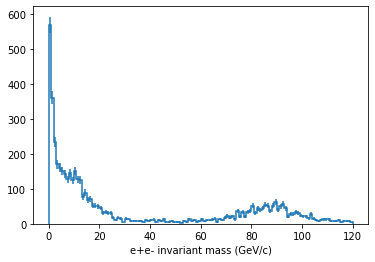

In [52]:
hM.plot();

By importing Matplotlib, we can configure the plot, mix it with other plots, tweak how it looks, etc.

In [53]:
import matplotlib.pyplot as plt

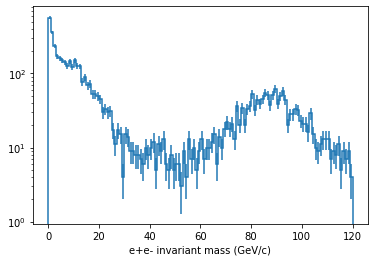

In [54]:
hM.plot()
plt.yscale("log")

**Physics note:** The broad peak at 85 GeV _is_ the Z boson (in this Monte Carlo sample). It's offset from the 91 GeV Z mass and has a width of 14 GeV due to tracking resolution for these high-momentum tracks (roughly 40 GeV per track).

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The `invariant_mass` array can be flattened with [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) or [ak.ravel](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ravel.html)/[np.ravel](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html). The [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) function only flattens one dimension (by default, `axis=1`), which is all we need in this case. "Ravel" is NumPy's spelling for "flatten all dimensions."

```python
flat_invariant_mass = ak.flatten(invariant_mass)
```
<br>

or

```python
flat_invariant_mass = np.ravel(invariant_mass)
```
<br>

The reason you have to do this manually is because it's an information-losing operation: [there are many ways](https://awkward-array.org/how-to-restructure-flatten.html) to get a dimensionless set of values from nested data, and in some circumstances, you might have wanted one of the other ones. For instance, maybe you want to ensure that you only plot one Z candidate per event, and you have some criteria for selecting the "best" one. This is where you would put that alternative.

As for constructing the histogram and filling it:

```python
hM = hist.Hist(hist.axis.Regular(120, 0, 120, label="e+e- invariant mass (GeV/c)"))
hM.fill(flat_invariant_mass)
```
<br>

Be sure to use hist's array-oriented `fill` method. Iterating over the values in the array (or even the lists withing an array of lists) would be hundreds of times slower than filling it in one call.

Calling `fill` multiple times to accumulate batches, however, is fine: the important thing is to give it a large array with each call, so that most of its time can be spent in its compiled histogram-fill loop, not in Python loops.</details>

### Retrospective

(Spoilers; keep hidden until you're done.)

This might have seemed like a lot of steps to produce a simple invariant mass plot, but the intention of the exercises above was to walk you through it slowly.

A speedrun would look more like this:

In [1]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import uproot
import particle
import hepunits
import hist
import vector
vector.register_awkward()

In [2]:
picodst = uproot.open("https://pivarski-princeton.s3.amazonaws.com/pythia_ppZee_run17emb.picoDst.root:PicoDst")

In [3]:
# make an array of track momentum vectors
pMom = ak.zip(dict(zip(["px", "py", "pz"], picodst.arrays(filter_name="Track.mPMomentum[XYZ]", how=tuple))), with_name="Momentum4D")
pMom["M"] = particle.Particle.find("e-").mass / hepunits.GeV

In [4]:
# get all the other arrays we need
mNHitsFit, mNHitsMax, mBEmcPidTraitsIndex, mBtowE = \
    picodst.arrays(filter_name=["Track.mNHitsFit", "Track.mNHitsMax", "Track.mBEmcPidTraitsIndex", "EmcPidTraits.mBtowE"], how=tuple)
mBtowE = mBtowE / 1000

In [5]:
# add charge to the momentum vector
pMom["charge"] = (mNHitsFit > 0) * 2 - 1

In [6]:
# compute track quality cuts
isPrimary = pMom.mag > 0
isBemcTrack = mBEmcPidTraitsIndex >= 0
track_quality_cuts = isPrimary & (abs(mNHitsFit) / mNHitsMax >= 0.2) & isBemcTrack

In [7]:
# find shower energies for quality tracks
quality_mBtowE = mBtowE[mBEmcPidTraitsIndex[track_quality_cuts]]

In [8]:
# compute the momentum-over-energy cut (some denominators are zero)
with np.errstate(divide="ignore"):
    quality_pOverE_cut = (pMom[track_quality_cuts].mag / quality_mBtowE >= 0.1)

In [9]:
# apply all track quality cuts, including momentum-over-energy
goodTracks = pMom[track_quality_cuts][quality_pOverE_cut]

In [10]:
# form pairs of quality cuts and apply an opposite-sign charge constraint
pairs = ak.combinations(goodTracks, 2)
one, two = ak.unzip(pairs)
quality_one, quality_two = ak.unzip(pairs[one.charge != two.charge])

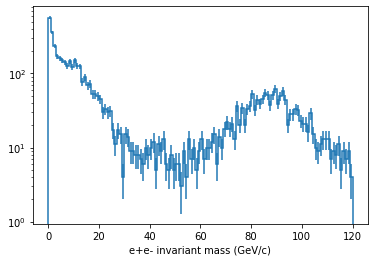

In [11]:
# make the plot
hM = hist.Hist(hist.axis.Regular(120, 0, 120, label="e+e- invariant mass (GeV/c)"))
hM.fill(ak.flatten((quality_one + quality_two).mass))
hM.plot()
plt.yscale("log")

#### **Final words about array-oriented data analysis**

The key thing about this interface is the _order_ in which you do things.

   1. Scan through the TBranch names to see what you can play with.
   2. Get some promising-looking arrays. If the dataset is big or remote, use `entry_stop=small_number` to fetch only as much as you need to investigate.
   3. Compute _one quantity_ on the _entire array(s)_. Then look at a few of its values or plot it.
   4. Decide whether that was what you wanted to compute or cut. If not, go back to 2.
   5. When you've built up a final result (on a small dataset), clean up the notebook or copy it to a non-notebook script.
   6. Put the computation code in an [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html) loop or a parallel process that writes and adds up histograms.
   7. Parallelize, collect the histograms, beautify them, publish.

Most importantly, each computation _step_ applies to _entire_ (possibly small) datasets, so you can look at/plot what you've computed before you decide what to compute next.

Imperative code forces you to put all steps into a loop; you have to run the whole loop to see any of the results. You can still do iterative data analysis, but the turn-around time to identify and fix mistakes is longer.

#### **I'm not just the president; I'm also a client**

I experienced this first-hand (again) while preparing this tutorial. There were some things I didn't understand about STAR's detectors and I didn't believe the final result (I thought the Z peak was fake; sculped by cuts), so I furiously plotted everything versus everything in this TTree until I came to understand that the Z peak was correct after all. (Dmitry Kalinkin helped: thanks!)

Offline, I have a ridiculously messy `Untitled.ipynb` with all those plots, mostly in the form

```python
plt.hist(ak.flatten(some_quantity), bins=100);  # maybe add range=(low, high)
plt.yscale("log")
```

for brevity. Only when _I_ felt _I_ understood what was going on could I clean up all of that mess into something coherent, which is the exercises above.